## Wokflow for Utah rock glacier coverage
Matt Olson - 02/2025

In [1]:
# import libraries and functions
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from shapely.geometry import Point
from matplotlib import pyplot as plt

import ee
import geemap 

# import json
from datetime import datetime
import os

In [2]:
# autheniticate
ee.Authenticate()
ee.Initialize()

In [3]:
## FUNCTIONS 1 - ndsi and pixel counts

# apply threshold to ndsi values (0.2 and 0.4 options)
def s2_threshold02(image):
    # return image.gte(-1).And(image.lte(0.2)).selfMask() # for upper and lower bounds
    return image.gte(0.2).selfMask() # greater than or equal to (gte)
def s2_threshold04(image):
    return image.gte(0.4).selfMask()

# scale values, clip, and run NDSI
def s2_ndsi_clip(image):
    image = image.divide(10000).clip(rg) # scale and clip
    index = image.normalizedDifference(['B3','B11']).rename('ndsi');
    return image.addBands(index)
def s2_scale_clip(image):
    image = image.divide(10000).clip(rg) # scale and clip
    return image

# Function to count pixels in an image
def count_pixels(image):
    total_pixels = image.select(0).reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=rg,
        scale=20,  # Adjust scale as needed
        maxPixels=1e13
    ).get(image.bandNames().get(0))
    return ee.Feature(None, {'image_id': image.id(), 'pixel_count': total_pixels})

# Function to extract date from image name and convert to datetime
def extract_date(image_name):
    # Extract the first part of the image name (before the first 'T')
    date_str = image_name.split('T')[0]
    
    # Convert the string into a datetime object
    date_obj = datetime.strptime(date_str, '%Y%m%d')
    
    return date_obj

def closest_to_oct15(group):
    oct15 = pd.Timestamp(f'{group["year"].iloc[0]}-10-15')  # October 15th of the year
    # Find the closest date before or after October 15
    before_oct15 = group[group['date'] <= oct15].iloc[-1]  # Closest before or on Oct 15
    after_oct15 = group[group['date'] >= oct15].iloc[0]  # Closest after or on Oct 15
    # Return the one with the minimum area_km2
    return before_oct15 if before_oct15['area_km2'] <= after_oct15['area_km2'] else after_oct15

In [4]:
# FUNCTIONS 2 - cloud masking

# Function to extract the cloud mask from the SCL band
def extract_cloud_mask(image):
    # Extract the Scene Classification (SCL) band
    scl_band = image.select('SCL')
    
    # Cloud values in SCL are marked by 8 (cloud) and 9 (cirrus)
    cloud_mask = scl_band.eq(8).Or(scl_band.eq(9))  # Cloud or Cirrus
    
    # Mask the image based on cloud mask
    return image.updateMask(cloud_mask.Not())  # Mask out clouds

# Function cloud coverage percentage for polygon (rg)
def cloud_coverage(image):
    # Extract the SCL band (Scene Classification) and create a cloud mask (cloud = 8, cirrus = 9)
    scl_band = image.select('SCL')
    cloud_mask = scl_band.eq(8).Or(scl_band.eq(9))  # Cloud or Cirrus
    
    # Count the number of cloud pixels using the cloud mask
    cloud_pixels = cloud_mask.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=rg,  # Provide the Region of Interest (ROI)
        scale=10,  # Sentinel-2 has a spatial resolution of 10 meters for SCL
        maxPixels=1e8
    ).get('SCL')  # The result will be stored under the 'SCL' key
    
    # Count the total number of pixels in the image
    total_pixels = image.select('SCL').reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=rg,  # Use the same ROI as the region of interest
        scale=10,  # Sentinel-2 has a spatial resolution of 10 meters for SCL
        maxPixels=1e8
    ).get('SCL')  # The result will be stored under the 'SCL' key
    
    # Calculate cloud coverage percentage
    cloud_percentage = ee.Number(cloud_pixels).divide(total_pixels).multiply(100)
    
    # Set the 'cloud_coverage' property on the image
    return image.set('cloud_coverage', cloud_percentage)

# Function cloud coverage and return the image name and cloud percentage in polygon
def extract_cloud_coverage(image):
    # Retrieve the image name and cloud coverage property
    image_name = image.get('system:index')  # This is the image name or index
    cloud_cover = image.get('cloud_coverage')  # Cloud coverage percentage
    
    # Return as an image with additional properties (for further processing)
    return image.set({'image_name': image_name, 'cloud_cover': cloud_cover})


In [5]:
# read in boundary
# rg = geemap.shp_to_ee('shp/timp-rg/timp.shp')
# rg = geemap.shp_to_ee('shp/timp-2025/timp-narrow-2025.shp')
rg = geemap.shp_to_ee('shp/timp-2025/timp-rootzone-2025.shp')
# rg = geemap.geojson_to_ee('data/Timp-rooting-zone-2025/Timpanogos_rooting_zone.geojson')

In [6]:
Map = geemap.Map()

rg_poly_params = {'color': '000000', 'pointSize': 3,'width': 2,'lineType': 'solid','fillColor': '00000000'}
Map.centerObject(rg, 14)
Map.addLayer(rg.style(**rg_poly_params), {}, "Rock glacier outline")

Map

Map(center=[40.387330402802654, -111.6406205847423], controls=(WidgetControl(options=['position', 'transparent…

## Sentinel-2

The Harmonized Sentinel 2 surface reflectance product is used first to standardize spectra over the full time period (2017-present). Offset values are added after January, 2022 to standard S-2 imagery. See [Sentinel-2 Datasets](https://developers.google.com/earth-engine/datasets/catalog/sentinel-2) for more information.

Initial filter includes:
* dates
* spatial
* cloud
* month range

*Images are mainly only seen at 2019 for this region.*

In [7]:
# filter collection (initial)
start_date = '2015-08-01' # Define the date range
end_date = '2024-10-31' 

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') # Define collection

# Filter by date, cloud, months, and region
s2_filtered = s2.filterDate(start_date, end_date).filterBounds(rg) \
                        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
                        .filter(ee.Filter.calendarRange(8, 10, 'month'))

In [8]:
s2_filtered # 83 for harmonized Sentinel-2 
# 2019-2024

In [8]:
## Filter for total scene coverage
# implimented later...

## Cloud masking

Cloud masking is agressive over snow covered, and partially snow covered, areas. Recommended to not directly use the masking, rather observe percentages in post-processing. This section creates a cloud masked dataset and adds a property to show where clouds have been classified with the *SLC* layer.

A dataframe is created to show cloud percentage over specieid area (polygon) of interest (rg).

Further work could be done with the CFMASK algorithm.

In [9]:
# Apply the cloud mask function to each image in the collection
s2_no_clouds = s2_filtered.map(extract_cloud_mask)

# Check if any image in the collection contains clouds
# image_with_clouds = s2_with_no_clouds.filter(ee.Filter.eq('system:cloud_coverage', 100)).first()

In [10]:
s2_no_clouds # this image omits cloudy areas
## strong correlation with snow - DON'T USE

In [11]:
# test filetered and cloud masked
Map = geemap.Map()
vis_params = {'min': 100, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}
Map.centerObject(rg, 14)
Map.addLayer(s2_filtered.first(), vis_params, 'RGB filtered')
Map.addLayer(s2_no_clouds.first(), vis_params, 'RGB cloud mask')
Map

Map(center=[40.387330402802654, -111.6406205847423], controls=(WidgetControl(options=['position', 'transparent…

In [12]:
# Observe cloud mask
Map = geemap.Map()
Map.centerObject(rg, 10)
# Add the first image to the map with the cloud mask applied
image = s2_filtered.first()
cloud_mask = image.select('SCL').eq(8).Or(image.select('SCL').eq(9))  # Clouds and Cirrus

Map.addLayer(image, {'min': 100, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}, 'RGB')
Map.addLayer(cloud_mask.updateMask(cloud_mask.neq(0)), {'min': 0, 'max': 1, 'palette': ['000000', 'blue']}, 'Cloud Mask')

# Display the map
Map

Map(center=[40.387330402802654, -111.6406205847423], controls=(WidgetControl(options=['position', 'transparent…

In [13]:
# show other scenes
Map = geemap.Map()

# first 10 scenes only
scene_number = 5 # 5 - "cloudless"

# get date
image_id = ee.Image(s2_filtered.toList(10).get(scene_number)).get('system:index').getInfo()
date_part = image_id.split('T')[0]; date_obj = datetime.strptime(date_part, '%Y%m%d')
formatted_date = date_obj.strftime('%m-%d-%Y')
print("Scene aquisition " + formatted_date)

# select images
image = ee.Image(s2_filtered.toList(10).get(scene_number))
cloud_mask = image.select('SCL').eq(8).Or(image.select('SCL').eq(9))  # Clouds and Cirrus

rg_poly_params = {'color': '000000', 'pointSize': 3,'width': 2,'lineType': 'solid','fillColor': '00000000'}
Map.centerObject(rg, 14)
# add original image, clouds (blue), rglacier outline (black)
Map.addLayer(image, {'min': 100, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}, \
             'RGB '  + formatted_date)
Map.addLayer(cloud_mask.updateMask(cloud_mask.neq(0)), \
             {'min': 0, 'max': 1, 'palette': ['000000', 'blue']}, 'RGB masked')
Map.addLayer(rg.style(**rg_poly_params), {}, "Rock glacier outline")

Map

Scene aquisition 09-13-2019


Map(center=[40.387330402802654, -111.6406205847423], controls=(WidgetControl(options=['position', 'transparent…

In [14]:
# Calculate cloud coverage within rg polygon

# Apply cloud coverage function to the image collection
s2_cloud_coverage = s2_filtered.map(cloud_coverage)

# Check cloud coverage of the first image in the collection
first_image = s2_cloud_coverage.first()
print("Cloud Coverage of First Image: ", first_image.get('cloud_coverage').getInfo())


Cloud Coverage of First Image:  0.05914198626086165


In [15]:
# Apply cloud coverage function to collection
s2_cloud_coverage_with_name = s2_cloud_coverage.map(extract_cloud_coverage)

# Get variables with aggregate_array()
image_names = s2_cloud_coverage_with_name.aggregate_array('image_name').getInfo()
cloud_coverage = s2_cloud_coverage_with_name.aggregate_array('cloud_cover').getInfo()

# create dataframe
df_cloud = pd.DataFrame({'image_name': image_names,'cloud_perc': cloud_coverage})
df_cloud.head(6)

image_name  cloud_perc
0  20190811T180929_20190811T182034_T12TVK    0.059142
1  20190816T180921_20190816T182055_T12TVK    0.000000
2  20190821T180919_20190821T181254_T12TVK    0.633274
3  20190826T180921_20190826T181707_T12TVK    0.000000
4  20190831T180919_20190831T181408_T12TVK    0.000000
5  20190913T181949_20190913T182552_T12TVK    0.000000

Cloud coverage should not be used to mask outimage but can be applied later to correct for situations where the entire outline is obscured by a small cloud *since an initial cloud filter is already applied to the image*.

## NDSI

For accurate index calculation, surface reflectance product must be scaled, prior to calculating the NDSI. Sentinel-2 [NDSI](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndsi/) uses B3 (*VIS or green*) and B11 (*SWIR*).

A threshold of **0.2** is applied rather than 0.4 to capture late season snow on the rock glacier (should find sources to support this).

Snow pixels at or above threshold value are counted and converted to area based on the input rock glacier polygon (rg).

In [16]:
# NDSI w/ THRESHOLD
# scale and clip imagery prior to ndsi calculation
s2_ndsi = s2_filtered.map(s2_ndsi_clip)
s2_clip = s2_filtered.map(s2_scale_clip)

# apply threshold of 0.2
s2_thresh = s2_ndsi.map(s2_threshold02) # s2_threshold04 also exists

In [17]:
# PIXEL COUNT DATAFRAME
# Map over the image collection
pix_count = s2_thresh.map(count_pixels)
pix_count_total = s2_ndsi.map(count_pixels)

# Convert to FeatureCollection and then pandas DataFrame
pix_count_collection = ee.FeatureCollection(pix_count)
df1 = geemap.ee_to_df(pix_count_collection)
pix_count_total_collection = ee.FeatureCollection(pix_count_total)
df2 = geemap.ee_to_df(pix_count_total_collection)
df2.rename(columns={'pixel_count': 'total_count'}, inplace=True)

# Display as table
# df_area = pd.concat([df, df2], axis=1) # df_area = df.join(df2)
# df_area = pd.merge(df1, df2, on=['image_id','image_id'])
df_area = pd.merge(df1, df2, left_index=True, right_index=True)
df_area.drop('image_id_y', axis=1, inplace=True)

# percent of coverage
max_pix = df_area['total_count'].max()
df_area['scene_perc'] = df_area['total_count'] / max_pix
df_area['snow_perc'] = df_area['pixel_count'] / max_pix
print(f"original dataset dimension: {df_area.shape}")

# create subset
scenep_cov = 1
dfa_sub = df_area[df_area['scene_perc'] >= scenep_cov]
# dfa_sub.drop(['total_count','scene_cover'], axis=1, inplace=True)
dfa_sub = dfa_sub.drop(['total_count','scene_perc'], axis=1)
print(f"scenes with full polygon coverage: {dfa_sub.shape[0]}")
print(f"removing {df_area.shape[0] - dfa_sub.shape[0]} scenes due to coverage less than {scenep_cov*100}%")


dfa_sub.head(5)

original dataset dimension: (81, 5)
scenes with full polygon coverage: 59
removing 22 scenes due to coverage less than 100%


image_id_x  pixel_count  snow_perc
0  20190811T180929_20190811T182034_T12TVK          110   0.982143
1  20190816T180921_20190816T182055_T12TVK          110   0.982143
2  20190821T180919_20190821T181254_T12TVK          110   0.982143
3  20190826T180921_20190826T181707_T12TVK          110   0.982143
4  20190831T180919_20190831T181408_T12TVK          112   1.000000

In [18]:
# DATAFRAME MERGE - add dates, area, and cloud percentage to pixel count
df2 = dfa_sub

# Apply the function to the 'image_name' column
df2['date'] = df2['image_id_x'].apply(extract_date)
df2 = df2.drop('image_id_x', axis=1)

# Calculate the area in square meters
df2['area_m2'] = df2['pixel_count'] * 400  # 400 m^2 per pixel (20m x 20m)
df2['area_km2'] = df2['pixel_count'] * 400 / 1_000_000 # sq km

# Add a column for the day of the year
df2['day_of_year'] = df2['date'].dt.dayofyear

# merge with cloud dataset
df_rg = pd.merge(df2, df_cloud, left_index=True, right_index=True)
cloudp_thresh = 75
df_rg = df_rg[df_rg['cloud_perc'] <= cloudp_thresh]
df_rg.drop('image_name', axis=1, inplace=True)
print(f"removing {dfa_sub.shape[0] - df_rg.shape[0]} scenes based on {cloudp_thresh}% cloud coverage")
print(f"final dataset dimension: {df_rg.shape}")

df_rg = df_rg.iloc[:,[2,5,0,1,3,4,6]]

df_rg.head(15)

removing 1 scenes based on 75% cloud coverage
final dataset dimension: (58, 7)


date  day_of_year  pixel_count  snow_perc  area_m2  area_km2  \
0  2019-08-11          223          110   0.982143    44000    0.0440   
1  2019-08-16          228          110   0.982143    44000    0.0440   
2  2019-08-21          233          110   0.982143    44000    0.0440   
3  2019-08-26          238          110   0.982143    44000    0.0440   
4  2019-08-31          243          112   1.000000    44800    0.0448   
6  2019-09-15          258          112   1.000000    44800    0.0448   
8  2019-09-25          268          112   1.000000    44800    0.0448   
9  2019-09-30          273          112   1.000000    44800    0.0448   
10 2019-10-03          276          112   1.000000    44800    0.0448   
11 2019-10-05          278          107   0.955357    42800    0.0428   
13 2019-10-15          288          101   0.901786    40400    0.0404   
15 2019-10-25          298          112   1.000000    44800    0.0448   
17 2020-08-10          223          104   0.928571    41600    0.0416   
18 2020-08-15          228           90   0.803571    36000    0.0360   
21 2020-08-30          243           90   0.803571    36000    0.0360   

    cloud_perc  
0     0.059142  
1     0.000000  
2     0.633274  
3     0.000000  
4     0.000000  
6     0.000000  
8     0.000000  
9    59.593285  
10    0.000000  
11    0.000000  
13    0.000000  
15    0.000000  
17   11.678268  
18    4.235476  
21    3.875165

In [19]:
# data is now subset based on 
df_rg # 59, 6 - from 83 orginal
print(f"The initial {df_area.shape[0]} filtered scenes \n were reduced to {df_rg.shape[0]} (based on scene and cloud coverage)")

The initial 81 filtered scenes 
 were reduced to 58 (based on scene and cloud coverage)


## Plots

First plots show timeseries for snow coverage extent over rock glacier polygon (rg) (pixels with ndsi >= 0.2 threshold).

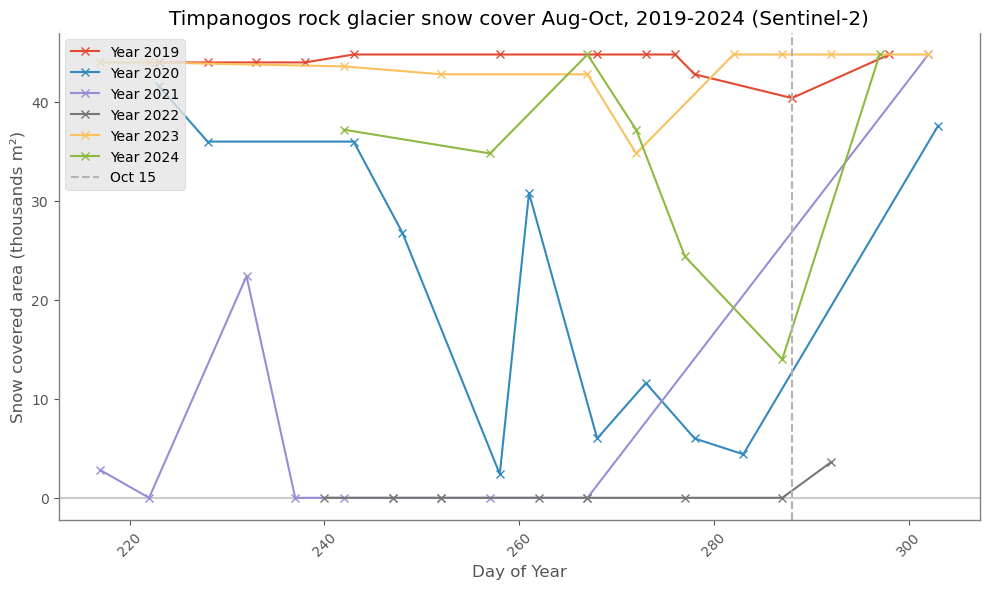

In [20]:
# plot 1
# all years 
# Plotting the area (in km²) over time with color by year
plt.style.use('ggplot')
# plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.set_facecolor('white')
ax.spines['bottom'].set_color('0.5')
ax.spines['right'].set_color('0.5'); ax.spines['left'].set_color('0.5')
plt.axhline(y=0, color='0.8', linestyle='-')

# Get unique years and plot each year with a different color
unique_years = df_rg['date'].dt.year.unique()
for year in unique_years:
    year_data = df_rg[df_rg['date'].dt.year == year]
    plt.plot(year_data['day_of_year'], year_data['area_m2']/1000, 
             label=f'Year {year}', marker='x')
    
plt.axvline(x=288, color='0.7', linestyle='--', label='Oct 15')
plt.title('Timpanogos rock glacier snow cover Aug-Oct, 2019-2024 (Sentinel-2)')
plt.xlabel('Day of Year')
plt.ylabel('Snow covered area (thousands m²)')
# plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title=None, loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()
# plt.savefig("figs/snowcover-sentinel2-end-season2.png")

In [100]:
# look at individual years
# df_rg[df_rg['date'].dt.year == 2021]

In [21]:
# check imagery for certain dates (if necessary
start_date_0 = '2021-10-28' # Define the date range
end_date_0 = '2021-10-31' 

# Filter by date, cloud, months, and region
s2_new = s2.filterDate(start_date_0, end_date_0).filterBounds(rg) \
                        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
                        .filter(ee.Filter.calendarRange(9, 10, 'month'))
print('Number of scenes', s2_new.size().getInfo())
Map = geemap.Map()
# ndsi_params = {'min': -1, 'max': 1, 'bands':'ndsi','palette': ['000FFF', '00FFFF']}
vis_params = {'min': 200, 'max': 6000, 'bands': ['B4', 'B3', 'B2']}
Map.centerObject(rg, 14)
Map.addLayer(s2_new.first(), vis_params, 'RGB')
# Map.addLayer(s2_ndsi.first().updateMask(s2_ndsi.first().gte(0.2)), ndsi_params, 'NDSI > 0.4')
Map

Number of scenes 1


Map(center=[40.387330402802654, -111.6406205847423], controls=(WidgetControl(options=['position', 'transparent…

In [22]:
# plot 3 
# df for min snow cover date
# df for min snow cover closest before/after Oct 15th

# Add a 'year' column to extract the year from the 'date'
df_rg['year'] = df_rg['date'].dt.year

# subset for minimum area_km2 per year
df_smin = df_rg.loc[df_rg.groupby('year')['area_m2'].idxmin()][['year', 'date', 'area_m2']]
# df_smin.rename(columns={'min_area': 'area_km2'}, inplace=True)

# subset for Minimum area_km2 for the closest date to October 15 of each year
df_oct15 = df_rg.groupby('year').apply(closest_to_oct15)[['date', 'area_m2']]

# combine and show restuls
# Merge the two DataFrames on the 'year' column using an outer join to keep all dates
dfsca = pd.merge(df_smin, df_oct15, on='year', how='outer', suffixes=('_min', '_closest'))
dfsca.head(6)
# dfsca_yr = pd.merge(df_smin, df_oct15, left_index=True, right_index=True)
# dfsca_yr.head(5)

year   date_min  area_m2_min date_closest  area_m2_closest
0  2019 2019-10-15        40400   2019-10-15            40400
1  2020 2020-09-14         2400   2020-10-09             4400
2  2021 2021-08-10            0   2021-09-24                0
3  2022 2022-08-28            0   2022-10-14                0
4  2023 2023-09-29        34800   2023-10-14            44800
5  2024 2024-10-13        14000   2024-10-13            14000

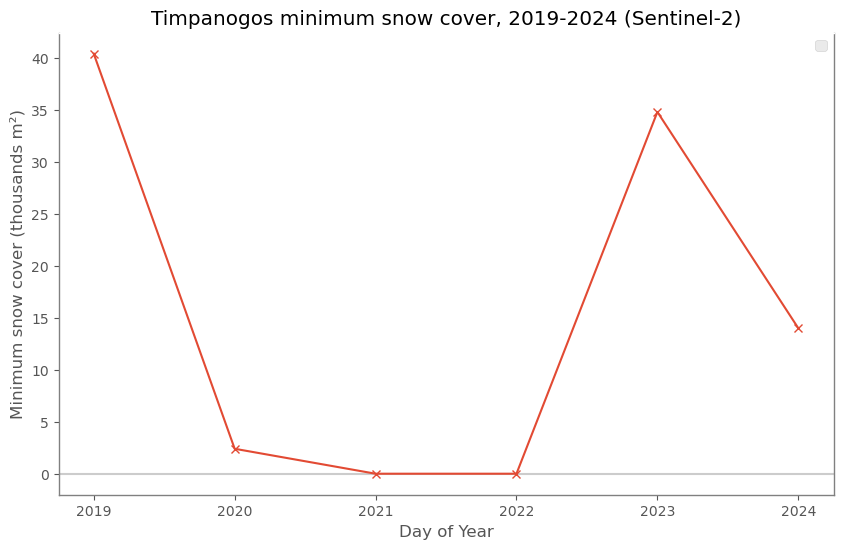

In [23]:
# plot 2 
# show minimum value from each year
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.set_facecolor('white')
ax.spines['bottom'].set_color('0.5')
ax.spines['right'].set_color('0.5'); ax.spines['left'].set_color('0.5')
plt.axhline(y=0, color='0.8', linestyle='-')

plt.plot(dfsca['year'], dfsca['area_m2_min']/1000, marker='x')
# dfsca.plot(x='year', y='area_km2_min', kind='line', marker='x', color='k')

plt.title('Timpanogos minimum snow cover, 2019-2024 (Sentinel-2)')
plt.xlabel('Day of Year')
plt.ylabel('Minimum snow cover (thousands m²)')
plt.legend("")
plt.grid(True)
plt.show()
# plt.savefig("figs/snowcover-sentinel2-annual2.png")

In [24]:
# dfsca.to_csv('results/s2_2019_2024_Timp_rootzone.csv', index=False)

In [74]:
# plot 3
# plt.style.use('ggplot')
# plt.figure(figsize=(10, 6))

# dfsca.plot(x='year', y='area_km2_closest', kind='line', marker='x', color='k')
# plt.title('Timpanogos glacier minimum snow cover area, 2019-2024 (Sentinel-2)')
# plt.xlabel('Day of Year')
# plt.ylabel('Minimum snow cover (km²)')
# plt.legend("")
# plt.grid(True)
# plt.show()

In [53]:
# Map 1
Map = geemap.Map()
ndsi_params = {'min': -1, 'max': 1, 'bands':'ndsi','palette': ['000FFF', '00FFFF']}
vis_params = {'min': 0, 'max': 0.35, 'bands': ['B4', 'B3', 'B2']}
Map.centerObject(rg, 14)
Map.addLayer(s2_clip.first(), vis_params, 'RGB')
Map.addLayer(s2_ndsi.first().updateMask(s2_ndsi.first().gte(0.2)), ndsi_params, 'NDSI > 0.4')
Map

Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [69]:
ee.Image(s2_ndsi.toList(max_scene).get(scene_number))

In [70]:
# plot any date

Map = geemap.Map()

scene_number = 18
max_scene = 20 # 10

image_id = ee.Image(s2_clip.toList(max_scene).get(scene_number)).get('system:index').getInfo()
date_part = image_id.split('T')[0]
date_obj = datetime.strptime(date_part, '%Y%m%d')
formatted_date = date_obj.strftime('%m-%d-%Y')

image = ee.Image(s2_clip.toList(max_scene).get(scene_number))
# img_ndsi = ee.Image(s2_ndsi.toList(max_scene).get(scene_number)).updateMask(s2_ndsi.first().gte(0.2))
img_ndsi = ee.Image(s2_ndsi.toList(max_scene).get(scene_number))
img_ndsi_mask = img_ndsi.updateMask(img_ndsi.gte(0.2))

Map.centerObject(rg, 15)
Map.addLayer(image, \
             {'min': 0, 'max': 0.35, 'bands': ['B4', 'B3', 'B2']}, formatted_date)
Map.addLayer(img_ndsi_mask, \
             {'min': -1, 'max': 1, 'bands':'ndsi','palette': ['000FFF', '00FFFF']}, 'NDSI > 0.2')
Map

Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [85]:
# Map 2
# with outline
Map = geemap.Map()
Map.centerObject(rg, 15)
poly_params = {'color': '000000', 'pointSize': 3,'width': 2,'lineType': 'solid','fillColor': '00000000'}
vis_params = {'min': 0, 'max': 0.35, 'bands': ['B4', 'B3', 'B2']}
ndsi_params = {'min': -1, 'max': 1, 'bands':'ndsi','palette': ['000FFF', '00FFFF']}
Map.centerObject(rg, 15)
Map.addLayer(s2_clip.first(), vis_params, 'RGB')
Map.addLayer(s2_ndsi.first().updateMask(s2_ndsi.first().gte(0.2)), ndsi_params, 'NDSI > 0.2')
Map.addLayer(rg.style(**poly_params), {}, "Timp rock glacier")
Map

Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [89]:
# Map 3
# different day plot
Map = geemap.Map()

scene_number = 4

image_id = ee.Image(s2_clip.toList(10).get(scene_number)).get('system:index').getInfo()
date_part = image_id.split('T')[0]
date_obj = datetime.strptime(date_part, '%Y%m%d')
formatted_date = date_obj.strftime('%m-%d-%Y')

vis_params = {'min': 0, 'max': 0.35, 'bands': ['B4', 'B3', 'B2']}
Map.centerObject(rg, 15)
Map.addLayer(ee.Image(s2_clip.toList(10).get(scene_number)), vis_params, formatted_date)

Map

Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [107]:
# Map 3
# reducer - showing the coverage minimum of each year

def count_unmasked_years(image):
    # Assume the mask is applied, with unmasked pixels having value 1, and masked pixels having value 0.
    # You could create a binary mask if needed for counting:
    unmasked_pixels = image.mask().reduceRegion(
        reducer=ee.Reducer.count(),  # Count the number of unmasked pixels
        geometry=rg,
        scale=30,  # Adjust scale to match the resolution of your image
        maxPixels=1e8
    )
    return unmasked_pixels

def create_unmasked_years_count_image(collection, roi):
    # Create a binary mask to count pixels that are unmasked
    def process_image(image):
        # Mask out the unmasked pixels with a value of 1 and masked pixels with a value of 0
        return image.updateMask(image.mask()).multiply(1)

    # Apply processing to the entire collection
    binary_images = collection.map(process_image)
    
    # Reduce the collection over time (count the unmasked years for each pixel)
    years_unmasked = binary_images.sum()
    
    return years_unmasked

# Example usage:
s2_thresh = s2_ndsi.filterBounds(rg)  # Make sure the collection is within the region of interest

# Now create the unmasked years count image
unmasked_years_image = create_unmasked_years_count_image(s2_thresh, rg).select([0])


In [108]:
unmasked_years_image

In [109]:
# Display the resulting image
Map = geemap.Map()
Map.centerObject(rg, 15)
Map.addLayer(unmasked_years_image, \
             {'min': 0, 'max': 10, 'palette': ['blue', 'green', 'yellow', 'red']}, \
             "Unmasked Years Count")
Map

Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [110]:

# Function to process and mask the image
def process_image(image):
    # Mask out the unmasked pixels (1 for unmasked, 0 for masked)
    return image.updateMask(image.mask()).multiply(1)

# Create an image that counts unmasked years per pixel
def create_unmasked_years_count_image(collection, roi):
    # Apply processing to the entire collection (binary mask with 1 for unmasked)
    binary_images = collection.map(process_image)
    
    # Reduce the collection over time by summing the binary values for each pixel
    years_unmasked = binary_images.sum()
    
    # Clip the result to the ROI for cleaner visualization
    years_unmasked_clipped = years_unmasked.clip(roi)
    
    return years_unmasked_clipped

# Example usage:
# Assuming s2_thresh is a valid image collection filtered for your region of interest (rg)
s2_ndsi2 = s2_ndsi.filterBounds(rg)  # Filter the collection for the region of interest

# Create the image that counts unmasked years per pixel
unmasked_years_image = create_unmasked_years_count_image(s2_ndsi2, rg)

# Inspect the minimum and maximum values to set appropriate visualization range
min_value = unmasked_years_image.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=rg,
    scale=30,  # Adjust as necessary
    maxPixels=1e8
).getInfo()

max_value = unmasked_years_image.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=rg,
    scale=30,  # Adjust as necessary
    maxPixels=1e8
).getInfo()

# Print out the minimum and maximum values to adjust the color scale
print(f"Min value: {min_value}")
print(f"Max value: {max_value}")

# If there's only one band, select the band explicitly (if necessary)
unmasked_years_image_band = unmasked_years_image.select([0])  # Select the first band if it's single-band

# Display the resulting image on the map
Map = geemap.Map()
Map.centerObject(rg, 10)  # Center the map on the region of interest

# Update color palette based on the min/max value
Map.addLayer(unmasked_years_image_band, {
    'min': 0, 
    'max': 10,  # Update this based on the min and max values
    'palette': ['blue', 'green', 'yellow', 'red']
}, "Unmasked Years Count")

# Show the map
# Map



Min value: {'AOT': 0.7018000000000001, 'B1': 11.5582, 'B11': 5.329999999999998, 'B12': 4.994599999999999, 'B2': 10.741599999999996, 'B3': 11.246899999999998, 'B4': 11.074499999999999, 'B5': 11.533500000000002, 'B6': 11.446499999999997, 'B7': 10.928900000000002, 'B8': 10.723899999999997, 'B8A': 10.5745, 'B9': 16.8237, 'MSK_CLASSI_CIRRUS': 0, 'MSK_CLASSI_OPAQUE': 0, 'MSK_CLASSI_SNOW_ICE': 0.0001, 'MSK_CLDPRB': 0.005399999999999999, 'MSK_SNWPRB': 0.0529, 'QA10': 0, 'QA20': 0, 'QA60': 0.6144000000000001, 'SCL': 0.034599999999999985, 'TCI_B': 0.7185000000000001, 'TCI_G': 0.7548999999999998, 'TCI_R': 0.7421999999999997, 'WVP': 2.2696999999999994, 'ndsi': -10.178221893940844}
Max value: {'AOT': 0.8437, 'B1': 24.251900000000003, 'B11': 17.7528, 'B12': 16.825299999999995, 'B2': 31.732699999999998, 'B3': 34.03779999999999, 'B4': 35.203, 'B5': 37.0302, 'B6': 36.020999999999994, 'B7': 34.6506, 'B8': 33.9713, 'B8A': 33.0717, 'B9': 29.418900000000004, 'MSK_CLASSI_CIRRUS': 0, 'MSK_CLASSI_OPAQUE': 0, 

In [106]:

# Export pixel count information to a dataframe
def get_pixel_counts(image):
    # Get the pixel values and count occurrences
    pixel_values = image.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=rg,
        scale=30,  # Adjust this scale as needed (use 10m for Sentinel-2)
        maxPixels=1e8
    )
    
    return pixel_values

# Get the pixel counts for the unmasked years image
pixel_counts = get_pixel_counts(unmasked_years_image_band)

# Convert to a dictionary and then to a pandas dataframe
pixel_counts_dict = pixel_counts.getInfo()

# Make sure we're only dealing with the actual pixel values, not band names like 'B1'
pixel_values_dict = pixel_counts_dict.get('0', {})  # Get the frequency histogram of the band

# Convert the dictionary to a DataFrame
counts_df = pd.DataFrame(list(pixel_values_dict.items()), columns=["Pixel Value", "Count"])

# Display the dataframe with the counts of each distinct value
print(counts_df)

Empty DataFrame
Columns: [Pixel Value, Count]
Index: []


## Extras

In [ ]:
# FAILED CLOUD MASK
# from: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED#description

# def mask_s2_clouds(image):
#   """Masks clouds in a Sentinel-2 image using the QA band.
#   Args:
#       image (ee.Image): A Sentinel-2 image.
#   Returns:
#       ee.Image: A cloud-masked Sentinel-2 image.
#   """
#   qa = image.select('QA60')

#   # Bits 10 and 11 are clouds and cirrus, respectively.
#   cloud_bit_mask = 1 << 10
#   cirrus_bit_mask = 1 << 11

#   # Both flags should be set to zero, indicating clear conditions.
#   mask = (
#       qa.bitwiseAnd(cloud_bit_mask)
#       .eq(0)
#       .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
#   )

#   return image.updateMask(mask).divide(10000)

# s2_collection = s2_filtered.map(mask_s2_clouds)

In [ ]:
# # Create an example ImageCollection (replace this with your own ImageCollection)

# collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
#     .filterBounds(rg) \
#     .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
#     .filter(ee.Filter.calendarRange(8, 11, 'month'))  
# # List of dates in 'YYYY-MM-DD' format
# dates_list = dfsca['date_min']

# # Convert the list to a format that Earth Engine can use
# dates = [ee.Date(date) for date in dates_list]

# # OLD
# # Filter the collection by each date in the list
# filtered_collection = ee.ImageCollection([collection.filterDate(date, date.advance(1, 'day')).first() for date in dates])

# # Print the filtered collection (just to check it)
# # print(filtered_collection.getInfo())

# # Initialize geemap Map
# Map = geemap.Map()
# Map.centerObject(rg, 14)
# vis_params = {'min': 0, 'max': 0.35, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}
# rg_poly_params = {'color': '000000', 'pointSize': 3,'width': 2,'lineType': 'solid','fillColor': '00000000'}

# # Add the images to the map
# for img in filtered_collection.getInfo()['features']:
#     img_id = img['id']
#     image = ee.Image(img_id)
#     Map.addLayer(image.multiply(0.0000275).add(-0.2), vis_params, f"RGB {img['properties']['system:time_start']}")

# Map.addLayer(rg.style(**rg_poly_params), {}, "Rock glacier outline")

# Map
